# Task 2: 3D Reconstruction [30]

**Please go through the notebook once before beginning working on it!**

In this notebook, we will extend our work from Task 1 to reconstruct a 3D model of a landmark using multiple images from the Heritage-Recon dataset.

<span style="color: red">**Submission Guidelines:**</span> Only one member of each group has to submit the file on LMS. The name of the file should be your group number. For example, if you are Group 1 then the file name should be **G01_Deliverable1.ipynb**. If you are unsure about your group number, then you can confirm it in the [sheet](https://docs.google.com/spreadsheets/d/1vN6JOLDWoFR5BnXTr0lMYGv_e9VzyAbqSUqf4VdjCQI/edit?gid=0#gid=0).

#### Imports

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.optimize import least_squares

# add imports here

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Dataset Loading & Preprocessing
Similar to what we did in Task 1, but instead of only a few images, we will now load in and preprocess all the images in our dataset

In [2]:
images_path = "../brandenburg_gate/brandenburg_gate/dense/SelectedImages"

image_files = sorted(os.listdir(images_path))

def is_image_file(filename):
    valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

valid_image_files = [file for file in image_files[2:] if is_image_file(file)]

In [3]:
def get_img_paths(folder_pth):
    """Returns a list containing filenames of all jpg files in folder_pth"""
    jpg_files = []

    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            filename = os.path.join(folder_pth, filename)
            jpg_files.append(filename)

    return jpg_files


def load_images(folder_pth):
    """Loads all images in folder_path"""
    images = []
    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_pth, filename))
            images.append(img)

    return images


def resize_image(img, size=(800, 600)):
    """Resizes image to a specified size."""
    return cv2.resize(img, size)


def convert_to_grayscale(img):
    """Converts an image to grayscale."""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def normalize_brightness(img):
    """Normalizes the brightness of an image using histogram equalization."""
    if len(img.shape) == 2:  
        return cv2.equalizeHist(img)
    elif len(img.shape) == 3:  
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

def preprocess_images(folder_pth, resize_dim=(800, 600)):
    """Loads, preprocesses, and returns images."""
    img_paths = get_img_paths(folder_pth)
    total_images = len(img_paths)
    preprocessed_images = []

    for i, path in enumerate(img_paths, start=1):
        img = cv2.imread(path)
        if img is not None:
            img = resize_image(img, size=resize_dim)  
            img = normalize_brightness(img) 
            img = convert_to_grayscale(img) 
            preprocessed_images.append(img)

        if i % 100 == 0 or i == total_images:
            print(f"Preprocessed {i}/{total_images} images")

    return preprocessed_images

Preprocessed 100/500 images
Preprocessed 200/500 images
Preprocessed 300/500 images
Preprocessed 400/500 images
Preprocessed 500/500 images


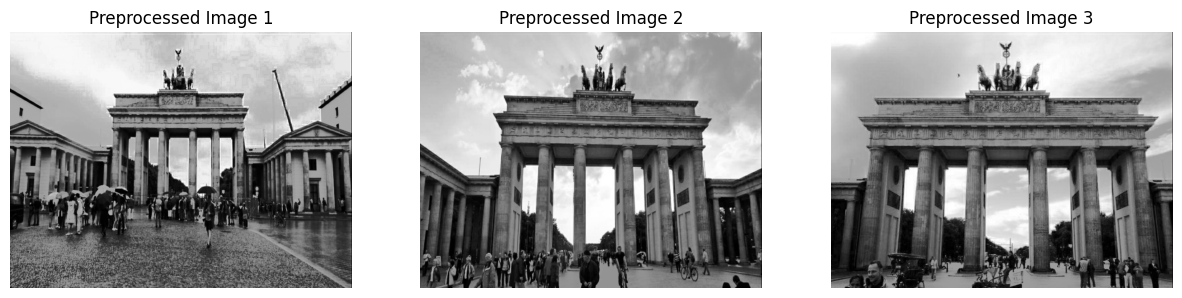

In [4]:
preprocessed_images = preprocess_images(images_path)

plt.figure(figsize=(15, 5))
for i, img in enumerate(preprocessed_images[:3]):  
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Preprocessed Image {i + 1}")
    plt.axis('off')
plt.show()

### Feature Detection & Matching (Across Multiple Images)
Extending what we did in Task 1, we will now extract the features from each image and match these features across all the images. However, this time you might want to consider extracting the best matches instead of all of them for each pair. Using the best matches improves the accuracy and reliability of our feature matching, which is crucial for the success of subsequent stages. Filtering out bad matches reduces the chance of errors propagating throughout the pipeline and results in a more robust and accurate 3D model.

Also display the results of feature detection and matching for any pair of images.

Image Pair 0-1: 66 refined matches after RANSAC.
Image Pair 1-2: 142 refined matches after RANSAC.
Image Pair 2-3: 99 refined matches after RANSAC.
Image Pair 3-4: 27 refined matches after RANSAC.
Image Pair 4-5: 24 refined matches after RANSAC.
Image Pair 5-6: 66 refined matches after RANSAC.
Image Pair 6-7: 185 refined matches after RANSAC.
Image Pair 7-8: 11 refined matches after RANSAC.
Image Pair 8-9: 37 refined matches after RANSAC.
Image Pair 9-10: 24 refined matches after RANSAC.
Image Pair 10-11: 19 refined matches after RANSAC.
Image Pair 11-12: 105 refined matches after RANSAC.
Image Pair 12-13: 10 refined matches after RANSAC.
Image Pair 13-14: 33 refined matches after RANSAC.
Image Pair 14-15: 29 refined matches after RANSAC.
Image Pair 15-16: 17 refined matches after RANSAC.
Image Pair 16-17: 43 refined matches after RANSAC.
Image Pair 17-18: 49 refined matches after RANSAC.
Image Pair 18-19: 29 refined matches after RANSAC.
Image Pair 19-20: 13 refined matches after RANS

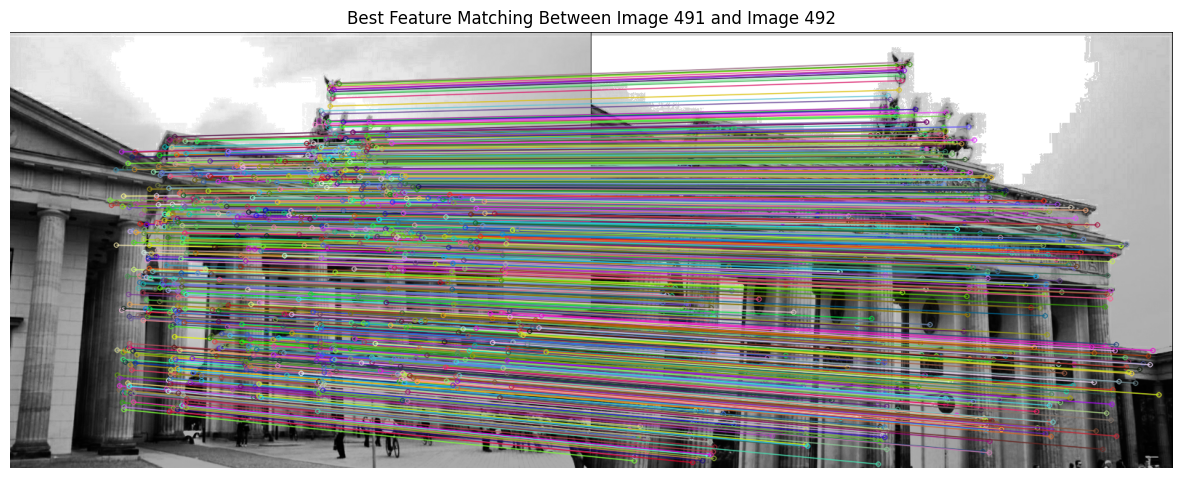

In [55]:
# Feature Detection and Matching

def detect_and_compute_features(img, detector):
    """Detect and compute features using the specified detector."""
    keypoints, descriptors = detector.detectAndCompute(img, None)
    return keypoints, descriptors

def match_features(desc1, desc2, matcher, ratio=0.75):
    """Match features between two sets of descriptors using Lowe's ratio test."""
    matches = matcher.knnMatch(desc1, desc2, k=2)
    good_matches = [m for m, n in matches if m.distance < ratio * n.distance]
    return good_matches

def filter_matches_with_ransac(kp1, kp2, matches, threshold=5.0):
    """Refine matches using RANSAC to find robust correspondences."""
    if len(matches) < 4:
        print("Not enough matches for RANSAC.")
        return []

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Compute homography using RANSAC
    _, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, threshold)
    
    # Filter matches based on the mask
    refined_matches = [m for m, inlier in zip(matches, mask.ravel()) if inlier]
    return refined_matches

def feature_detection_and_matching(images, ratio_threshold=0.75, ransac_threshold=20.0):
    # Initialize SIFT detector and BFMatcher
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    keypoints_all = []
    descriptors_all = []

    # Detect keypoints and compute descriptors for all images
    for img in images:
        keypoints, descriptors = detect_and_compute_features(img, sift)
        keypoints_all.append(keypoints)
        descriptors_all.append(descriptors)

    matches_list = []

    # Match features for consecutive image pairs
    for i in range(len(images) - 1):
        desc1 = descriptors_all[i]
        desc2 = descriptors_all[i + 1]

        if desc1 is not None and desc2 is not None:
            # Match features using Lowe's ratio test
            good_matches = match_features(desc1, desc2, bf, ratio_threshold)

            # Refine matches using RANSAC
            kp1 = keypoints_all[i]
            kp2 = keypoints_all[i + 1]
            refined_matches = filter_matches_with_ransac(kp1, kp2, good_matches, ransac_threshold)

            matches_list.append(refined_matches)
            print(f"Image Pair {i}-{i + 1}: {len(refined_matches)} refined matches after RANSAC.")
        else:
            matches_list.append([])
            print(f"Image Pair {i}-{i + 1}: No descriptors found.")

    return keypoints_all, descriptors_all, matches_list

def visualize_best_matches(images, keypoints_all, matches_list):
    """Visualize matches for the image pair with the highest number of good matches."""
    # Find the pair with the maximum matches
    match_counts = [len(matches) for matches in matches_list]
    best_pair_index = match_counts.index(max(match_counts))
    
    # Extract the corresponding images, keypoints, and matches
    img1 = images[best_pair_index]
    img2 = images[best_pair_index + 1]
    kp1 = keypoints_all[best_pair_index]
    kp2 = keypoints_all[best_pair_index + 1]
    matches = matches_list[best_pair_index]

    # Draw matches
    matched_img = cv2.drawMatches(
        img1, kp1, img2, kp2, matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Display the result
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Best Feature Matching Between Image {best_pair_index + 1} and Image {best_pair_index + 2}")
    plt.axis('off')
    plt.show()


keypoints_all, descriptors_all, matches_list = feature_detection_and_matching(preprocessed_images)
visualize_best_matches(preprocessed_images, keypoints_all, matches_list)

### Camera Pose Estimation (Global)
We will estimate the relative camera poses (position and orientation) between consecutive image pairs. You can use the same technique as you did in Task 1 or switch to one of the others mentioned in the announcement on Slack.

In [ ]:
import os
import numpy as np
import cv2
from colmap.scripts.python.read_write_model import read_cameras_binary, read_images_binary

# Paths to the COLMAP binary files and subset of images
camera_bin_path = "../brandenburg_gate/brandenburg_gate/neuralsfm/cameras.bin"
images_bin_path = "../brandenburg_gate/brandenburg_gate/neuralsfm/images.bin"
subset_image_dir = "../brandenburg_gate/brandenburg_gate/dense/SelectedImages/"

cameras = read_cameras_binary(camera_bin_path)
images = read_images_binary(images_bin_path)

subset_filenames = set(os.listdir(subset_image_dir))  
subset_filenames = {os.path.basename(f) for f in subset_filenames}  

K_matrices = {}

filtered_images = {img_id: image for img_id, image in images.items() if image.name in subset_filenames}

for img_id, image in filtered_images.items():
    camera_id = image.camera_id
    camera = cameras[camera_id]
    params = camera.params
    fx, fy, cx, cy = params[:4]

    K = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0, 0, 1]
    ])
    K_matrices[image.name] = K

def estimate_camera_pose_dynamic(matches, kp1, kp2, K1, K2):
    """Estimates the relative camera pose between two images."""
    if not matches:
        print("No matches found. Skipping pose estimation.")
        return None, None

    try:
        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

        F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

        if F is None or F.shape != (3, 3):
            print("Invalid Fundamental Matrix. Skipping pose estimation.")
            return None, None

        E = K2.T @ F @ K1

        _, R, T, _ = cv2.recoverPose(E, pts1, pts2, K1)

        return R, T
    except IndexError as e:
        print(f"IndexError during pose estimation: {e}. Skipping this pair.")
        return None, None

keypoints_all = {name: kps for name, kps in zip(list(K_matrices.keys()), keypoints_all)}
descriptors_all = {name: desc for name, desc in zip(list(K_matrices.keys()), descriptors_all)}

global_poses = [np.eye(4)]  

# Process each image pair
for i, image1_name in enumerate(list(K_matrices.keys())[:-1]):
    image2_name = list(K_matrices.keys())[i + 1]

    kp1, desc1 = keypoints_all[image1_name], descriptors_all[image1_name]
    kp2, desc2 = keypoints_all[image2_name], descriptors_all[image2_name]
    matches = matches_list[i]

    if matches:
        # Get dynamic K matrices
        K1 = K_matrices[image1_name]
        K2 = K_matrices[image2_name]

        # Estimate relative pose
        R, T = estimate_camera_pose_dynamic(matches, kp1, kp2, K1, K2)

        if R is not None and T is not None:
            transformation = np.eye(4)
            transformation[:3, :3] = R
            transformation[:3, 3] = T[:, 0]

            global_pose = global_poses[-1] @ transformation
            global_poses.append(global_pose)

            print(f"Processed image pair: {image1_name} -> {image2_name}")
        else:
            print(f"Pose estimation failed for: {image1_name} -> {image2_name}")
            global_poses.append(np.eye(4))
    else:
        print(f"Skipping pair: {image1_name}, {image2_name} due to missing matches.")
        global_poses.append(np.eye(4))

Processed image pair: 60841688_8298465546.jpg -> 60770994_853214983.jpg
Processed image pair: 60770994_853214983.jpg -> 60732645_2978928712.jpg
Processed image pair: 60732645_2978928712.jpg -> 60691378_320372293.jpg
Processed image pair: 60691378_320372293.jpg -> 60633305_3067485286.jpg
Processed image pair: 60633305_3067485286.jpg -> 60553649_2254779884.jpg
Processed image pair: 60553649_2254779884.jpg -> 60473547_4365702274.jpg
Processed image pair: 60473547_4365702274.jpg -> 60240609_7333978098.jpg
Processed image pair: 60240609_7333978098.jpg -> 60052444_281239788.jpg
Processed image pair: 60052444_281239788.jpg -> 59869733_4041190569.jpg
Processed image pair: 59869733_4041190569.jpg -> 59826471_8014732885.jpg
Processed image pair: 59826471_8014732885.jpg -> 59713287_6809504619.jpg
Processed image pair: 59713287_6809504619.jpg -> 59311169_8993668355.jpg
Processed image pair: 59311169_8993668355.jpg -> 59225698_5908834267.jpg
Processed image pair: 59225698_5908834267.jpg -> 59062671

In [47]:
print(len(global_poses))

500


### Choosing the technique
For this task, you have been given the choice of using either Structure from Motion (SfM) or Photogrammetry as your reconstruction method. A brief overview of the steps involved in each technique has been included in the handout provided to you. You can choose either technique for this task but before you choose one be sure to do a bit more research on each technique. I have also added some resources below to help you in understanding each technique.

[Understanding Structure From Motion Algorithms](https://medium.com/@loboateresa/understanding-structure-from-motion-algorithms-fc034875fd0c)\
[SfM](https://cmsc426.github.io/sfm/)\
[Chapter 13 - Structure from motion](https://mi.eng.cam.ac.uk/~cipolla/publications/contributionToEditedBook/2008-SFM-chapters.pdf)\
[What is Photogrammetry?](https://www.artec3d.com/learning-center/what-is-photogrammetry)\
[The Multi-View Environment](https://github.com/simonfuhrmann/mve)\
[open Multi-View Stereo](https://github.com/cdcseacave/openMVS)\
[Surface Reconstruction](https://www.open3d.org/docs/latest/tutorial/Advanced/surface_reconstruction.html)

**Technique chosen:** SFM

### 3D Reconstruction
Once you have chosen the technique, you can now start working on actually 3D reconstruction. Depending on the technique, follow the pipeline to generate the 3D point cloud for your landmark.

Processing image pair 1/499...
  Triangulated 66 points for this pair.
Processing image pair 2/499...
  Triangulated 142 points for this pair.
Processing image pair 3/499...
  Triangulated 99 points for this pair.
Processing image pair 4/499...
  Triangulated 27 points for this pair.
Processing image pair 5/499...
  Triangulated 24 points for this pair.
Processing image pair 6/499...
  Triangulated 66 points for this pair.
Processing image pair 7/499...
  Triangulated 185 points for this pair.
Processing image pair 8/499...
  Triangulated 11 points for this pair.
Processing image pair 9/499...
  Triangulated 37 points for this pair.
Processing image pair 10/499...
  Triangulated 24 points for this pair.
Processing image pair 11/499...
  Triangulated 19 points for this pair.
Processing image pair 12/499...
  Triangulated 105 points for this pair.
Processing image pair 13/499...
  Triangulated 10 points for this pair.
Processing image pair 14/499...
  Triangulated 33 points for this pair

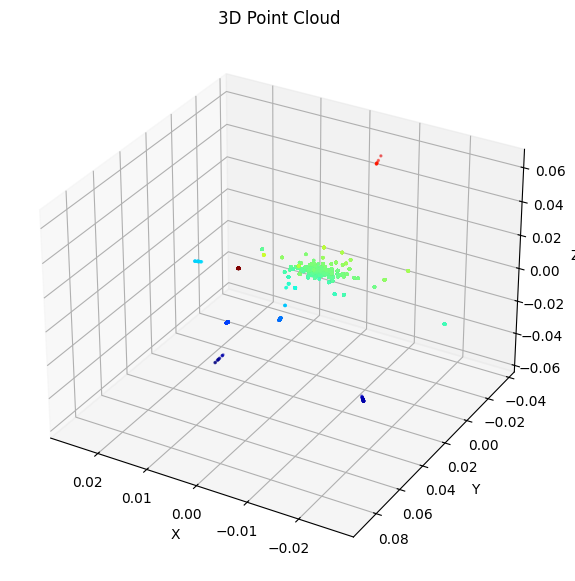

Image Pair 1: 66 matches
Image Pair 2: 142 matches
Image Pair 3: 99 matches
Image Pair 4: 27 matches
Image Pair 5: 24 matches
Image Pair 6: 66 matches
Image Pair 7: 185 matches
Image Pair 8: 11 matches
Image Pair 9: 37 matches
Image Pair 10: 24 matches
Image Pair 11: 19 matches
Image Pair 12: 105 matches
Image Pair 13: 10 matches
Image Pair 14: 33 matches
Image Pair 15: 29 matches
Image Pair 16: 17 matches
Image Pair 17: 43 matches
Image Pair 18: 49 matches
Image Pair 19: 29 matches
Image Pair 20: 13 matches
Image Pair 21: 25 matches
Image Pair 22: 90 matches
Image Pair 23: 47 matches
Image Pair 24: 12 matches
Image Pair 25: 194 matches
Image Pair 26: 82 matches
Image Pair 27: 172 matches
Image Pair 28: 63 matches
Image Pair 29: 6 matches
Image Pair 30: 7 matches
Image Pair 31: 184 matches
Image Pair 32: 57 matches
Image Pair 33: 48 matches
Image Pair 34: 58 matches
Image Pair 35: 38 matches
Image Pair 36: 31 matches
Image Pair 37: 41 matches
Image Pair 38: 13 matches
Image Pair 39: 29

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def triangulate_points(matches, kp1, kp2, pose1, pose2, K1, K2):
    """
    Triangulates 3D points between two camera poses and matched keypoints.
    """
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Normalize points using intrinsic matrices
    pts1_normalized = cv2.undistortPoints(np.expand_dims(pts1, axis=1), K1, None)
    pts2_normalized = cv2.undistortPoints(np.expand_dims(pts2, axis=1), K2, None)

    # Build projection matrices
    proj_matrix1 = K1 @ pose1[:3]
    proj_matrix2 = K2 @ pose2[:3]

    # Triangulate points
    points_4d = cv2.triangulatePoints(proj_matrix1, proj_matrix2, pts1_normalized, pts2_normalized)
    points_3d = points_4d[:3] / points_4d[3]  # Convert to Euclidean
    return points_3d.T

def build_sparse_point_cloud(matches_list, keypoints_all, global_poses, K_matrices):
    """
    Builds a sparse 3D point cloud by triangulating points for all image pairs.
    """
    point_cloud = []
    for i in range(len(matches_list)):
        print(f"Processing image pair {i + 1}/{len(matches_list)}...")

        # Retrieve data for this pair
        image1_name = list(K_matrices.keys())[i]
        image2_name = list(K_matrices.keys())[i + 1]
        kp1, kp2 = keypoints_all[image1_name], keypoints_all[image2_name]
        matches = matches_list[i]

        pose1 = global_poses[i]
        pose2 = global_poses[i + 1]

        K1 = K_matrices[image1_name]
        K2 = K_matrices[image2_name]

        # Triangulate points for this pair
        points_3d = triangulate_points(matches, kp1, kp2, pose1, pose2, K1, K2)
        point_cloud.extend(points_3d)

        print(f"  Triangulated {len(points_3d)} points for this pair.")
    
    print(f"Total 3D points: {len(point_cloud)}")
    return np.array(point_cloud)

def visualize_point_cloud(points_3d, elevation=30, azimuth=45):
    """
    Visualizes the 3D point cloud using Matplotlib with customizable angles.
    """
    print(f"Visualizing {len(points_3d)} 3D points...")

    points_3d = points_3d / np.linalg.norm(points_3d, axis=0).max()

    # 3D scatter plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    x = points_3d[:, 0]
    y = points_3d[:, 1]
    z = points_3d[:, 2]

    ax.scatter(x, y, z, s=2, c=z, cmap='jet', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Point Cloud')

    # Set the viewing angle
    ax.view_init(elev=elevation, azim=azimuth)

    plt.show()

sparse_point_cloud = build_sparse_point_cloud(matches_list, keypoints_all, global_poses, K_matrices)

visualize_point_cloud(sparse_point_cloud, elevation=30, azimuth=120)

for i, matches in enumerate(matches_list):
    print(f"Image Pair {i + 1}: {len(matches)} matches")
for i, pose in enumerate(global_poses):
    print(f"Camera {i + 1} Pose:\n{pose}\n")

### Mesh Generation & Texturing
Convert the 3D points generated into a 3D mesh and apply textures to it. You can use techniques like Poisson Surface Reconstruction for creating the mesh. For texturing, project the images onto the mesh based on the camera poses.

In [ ]:
# your code here

### Visualization
Visualize the 3D model once you have generated it

In [ ]:
# your code here
import open3d as o3d
import numpy as np

# Function for generating the mesh
def generate_mesh(points_3d):
    """Generate a 3D mesh using Poisson Surface Reconstruction."""
    print("Generating mesh from point cloud...")

    # Create a point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d)

    # Estimate normals for Poisson reconstruction
    print("Estimating normals...")
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    
    # Poisson Surface Reconstruction
    print("Performing Poisson surface reconstruction...")
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8)
    
    # Remove low-density triangles
    print("Cleaning up the mesh...")
    densities = np.asarray(densities)
    vertices_to_remove = densities < np.quantile(densities, 0.01)  # Remove bottom 1% density vertices
    mesh.remove_vertices_by_mask(vertices_to_remove)

    return mesh

# Function for visualizing the mesh
def visualize_mesh(mesh):
    """Visualize the generated 3D mesh."""
    print("Visualizing mesh...")
    mesh.compute_vertex_normals()  # Recompute normals for better shading
    o3d.visualization.draw_geometries(
        [mesh],
        window_name="3D Mesh Visualization",
        mesh_show_back_face=True  # Show back-facing triangles
    )

print("Starting 3D mesh generation...")
mesh = generate_mesh(sparse_point_cloud)

print("Starting visualization...")
visualize_mesh(mesh)

Starting 3D mesh generation...
Generating mesh from point cloud...
Estimating normals...
Performing Poisson surface reconstruction...
Cleaning up the mesh...
Starting visualization...
Visualizing mesh...


### Save your model
Save the results from the 3D reconstruction process, which includes:

- The 3D point cloud data (sparse or dense depending on the method you used).
- The camera poses (rotation and translation matrices).
  
This step is essential for documenting and visualizing your results, and also for use in the final task. You can save the data in formats like .ply for point clouds or .obj for meshes, and save the matrices in standard formats like .npz (for NumPy arrays).

In [ ]:
# Save point cloud to .ply
def save_point_cloud(filename, points_3d):
    with open(filename, 'w') as f:
        f.write("ply\nformat ascii 1.0\n")
        f.write(f"element vertex {len(points_3d)}\n")
        f.write("property float x\nproperty float y\nproperty float z\n")
        f.write("end_header\n")
        for p in points_3d:
            f.write(f"{p[0]} {p[1]} {p[2]}\n")

save_point_cloud("sparse_point_cloud.ply", sparse_point_cloud)

# Save poses to .npz
np.savez("camera_poses.npz", poses=np.array(global_poses))

### Evaluation
Evaluate the quality of your model. You can talk about how successfully you were able to reconstruct the landmark including aspects such as geometry accuracy, completeness, and texture detail (An answer of 5-6 lines will suffice).

**ANS:** Our reconstruction is not optimal because the order of images in our sequential pairing did not ensure smooth transitions between views, leading to gaps and inaccuracies in some parts of the model. However, the top of the landmark was reconstructed quite well since it appeared prominently in almost all image pairs, ensuring robust feature matching and triangulation. The lower sections suffered from incomplete geometry due to fewer overlapping keypoints between adjacent pairs. Additionally, texture detail is limited because the sparse reconstruction focuses more on geometry than dense texture mapping. Future improvements could involve reordering images or using global feature matching strategies